# Rag From Scratch: Routing

Routing

Routing is the next step of routing that decomposed questions into its relevant answer. 
Routing the question correctly to VectorDB, Relational DB or Graph DB to fetch the correct data. 




There are 2 different ways of routing :

	1. Logical Routing : In this case, we are giving LLM the knowledge of all the data sources we have. And the LLM will figure out to which one the question to be applied. So the LLM is applying some logic for determining which data source should be used. 
Semantic Routing : Take a question, embed it and compare  the similarity from embedded data and retrieve it.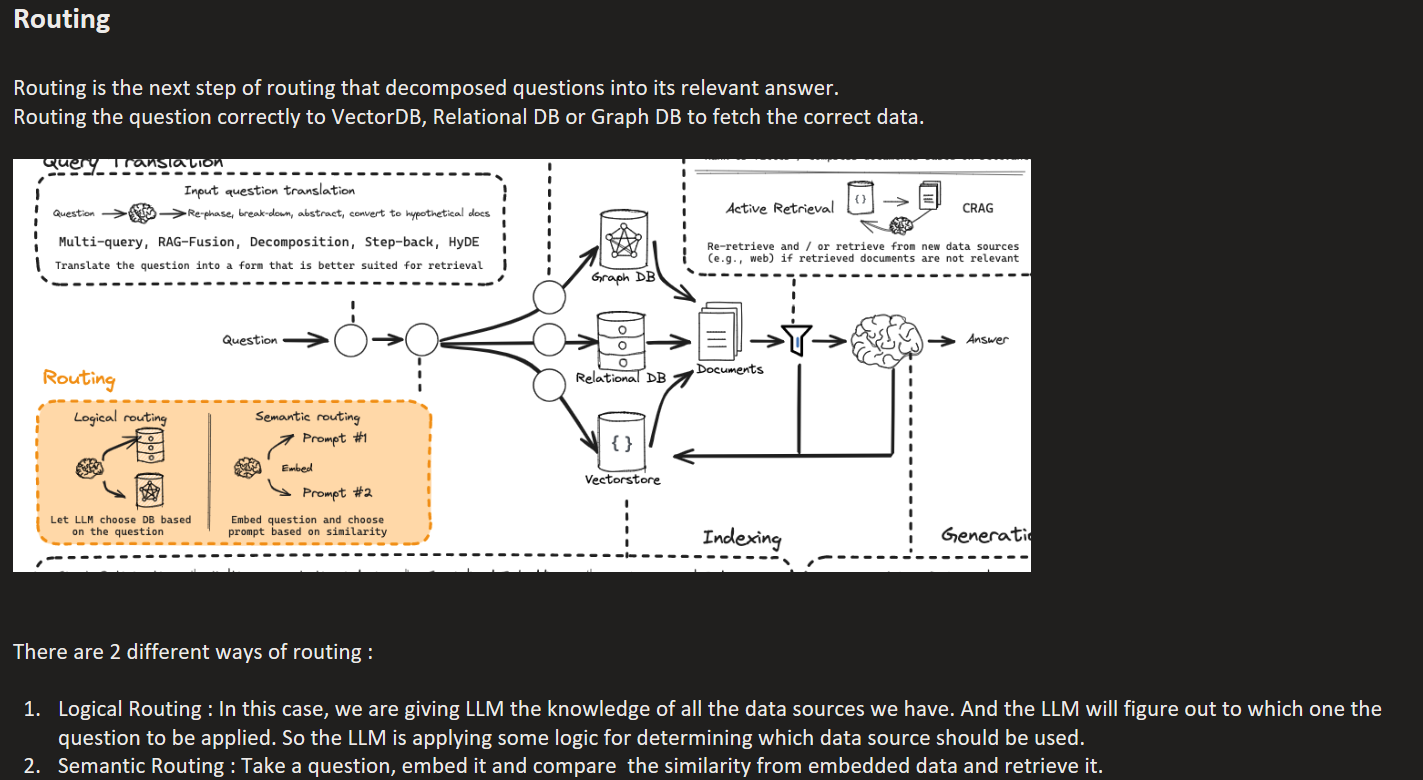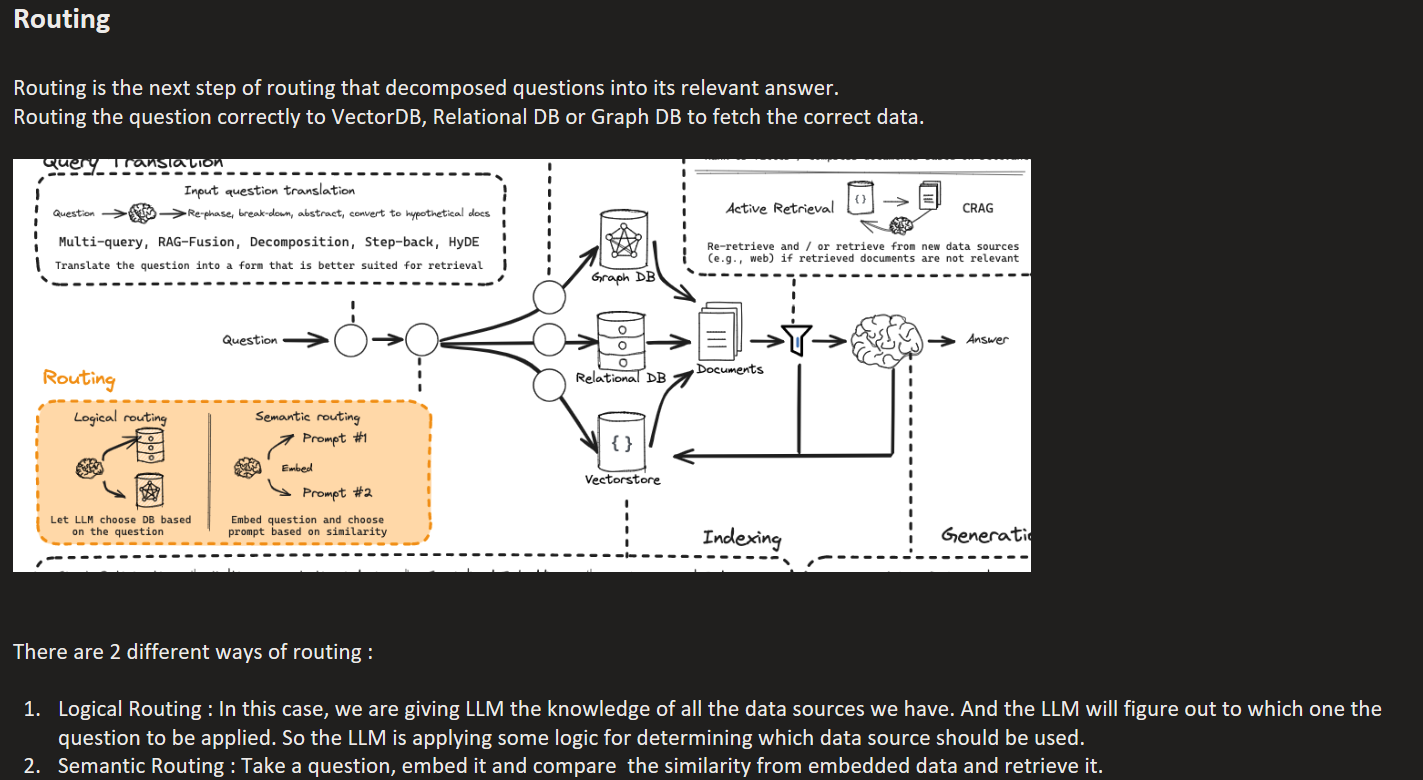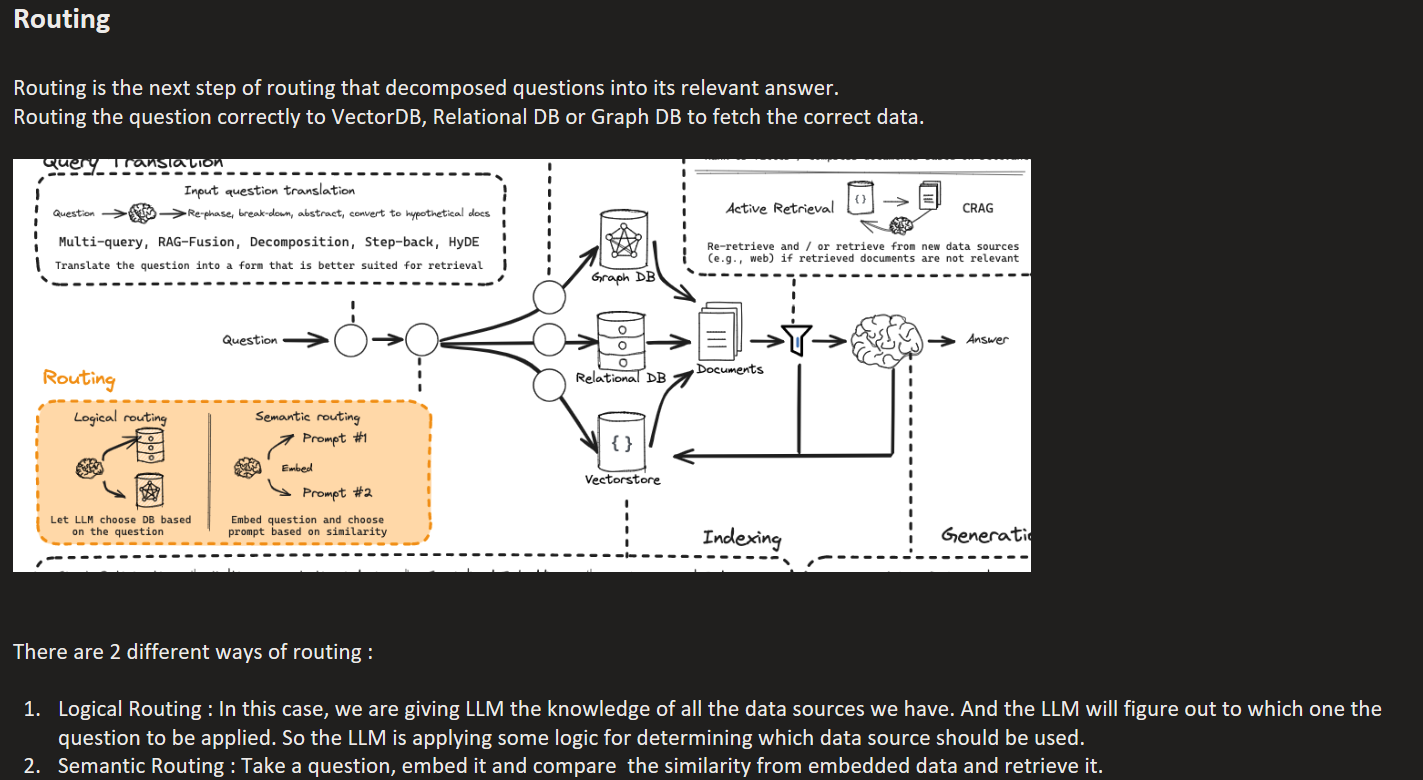

## Enviornment

In [2]:
! pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain youtube-transcript-api pytube

   ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
   ----------------------------------- ---- 51.2/57.6 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 57.6/57.6 kB 1.0 MB/s eta 0:00:00


(2) LangSmith

https://docs.smith.langchain.com/

In [3]:
import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = ""

(3) API Keys

In [5]:
os.environ['OPENAI_API_KEY'] = ""

## Part 10: Logical and Semantic routing
Use function-calling for classification.

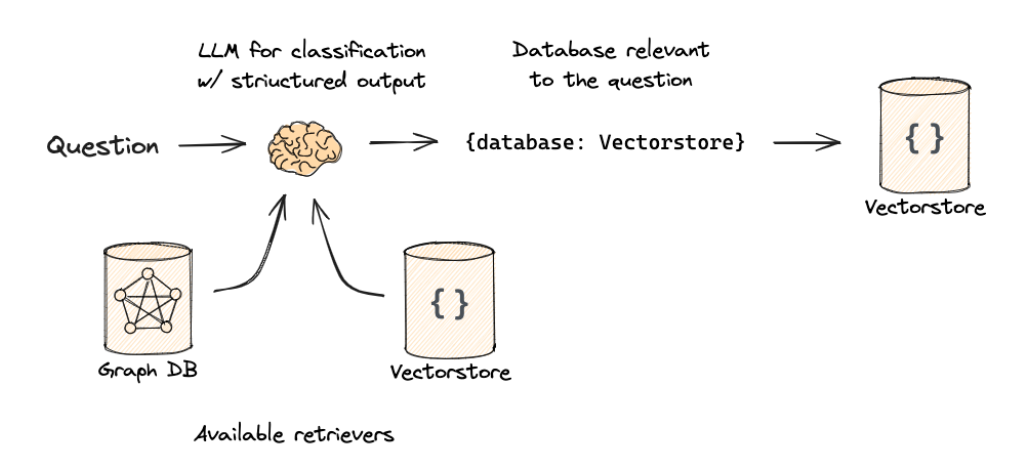

In [6]:
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["python_docs", "js_docs", "golang_docs"] = Field(
        ...,
        description="Given a user question choose which datasource would be most relevant for answering their question",
    )

# LLM with function call 
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm = llm.with_structured_output(RouteQuery)

# Prompt 
system = """You are an expert at routing a user question to the appropriate data source.

Based on the programming language the question is referring to, route it to the relevant data source."""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

# Define router 
router = prompt | structured_llm

In [7]:
question = """Why doesn't the following code work:

from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(["human", "speak in {language}"])
prompt.invoke("french")
"""

result = router.invoke({"question": question})

In [8]:
result

RouteQuery(datasource='python_docs')

In [9]:
result.datasource

'python_docs'

Once we have this, it is trivial to define a branch that uses result.datasource

In [10]:
def choose_route(result):
    if "python_docs" in result.datasource.lower():
        ### Logic here 
        return "chain for python_docs"
    elif "js_docs" in result.datasource.lower():
        ### Logic here 
        return "chain for js_docs"
    else:
        ### Logic here 
        return "golang_docs"

from langchain_core.runnables import RunnableLambda

full_chain = router | RunnableLambda(choose_route)

In [11]:
full_chain.invoke({"question": question})

'chain for python_docs'

## Semantic routing

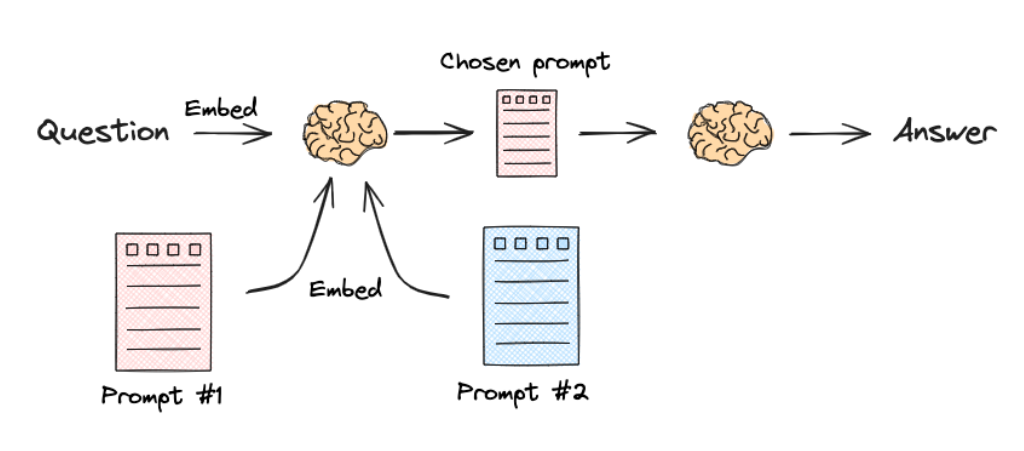

In [12]:
from langchain.utils.math import cosine_similarity
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# Two prompts
physics_template = """You are a very smart physics professor. \
You are great at answering questions about physics in a concise and easy to understand manner. \
When you don't know the answer to a question you admit that you don't know.

Here is a question:
{query}"""

math_template = """You are a very good mathematician. You are great at answering math questions. \
You are so good because you are able to break down hard problems into their component parts, \
answer the component parts, and then put them together to answer the broader question.

Here is a question:
{query}"""

# Embed prompts
embeddings = OpenAIEmbeddings()
prompt_templates = [physics_template, math_template]
prompt_embeddings = embeddings.embed_documents(prompt_templates)

# Route question to prompt 
def prompt_router(input):
    # Embed question
    query_embedding = embeddings.embed_query(input["query"])
    # Compute similarity
    similarity = cosine_similarity([query_embedding], prompt_embeddings)[0]
    most_similar = prompt_templates[similarity.argmax()]
    # Chosen prompt 
    print("Using MATH" if most_similar == math_template else "Using PHYSICS")
    return PromptTemplate.from_template(most_similar)


chain = (
    {"query": RunnablePassthrough()}
    | RunnableLambda(prompt_router)
    | ChatOpenAI()
    | StrOutputParser()
)

print(chain.invoke("What's a black hole"))

Using PHYSICS
A black hole is a region in space where the gravitational pull is so strong that nothing, not even light, can escape from it. This happens when a massive star collapses in on itself, creating a singularity with infinite density and a gravitational field that warps spacetime. Black holes can come in different sizes, from small stellar black holes to supermassive black holes found at the centers of galaxies.


# Rag From Scratch: Query Construction

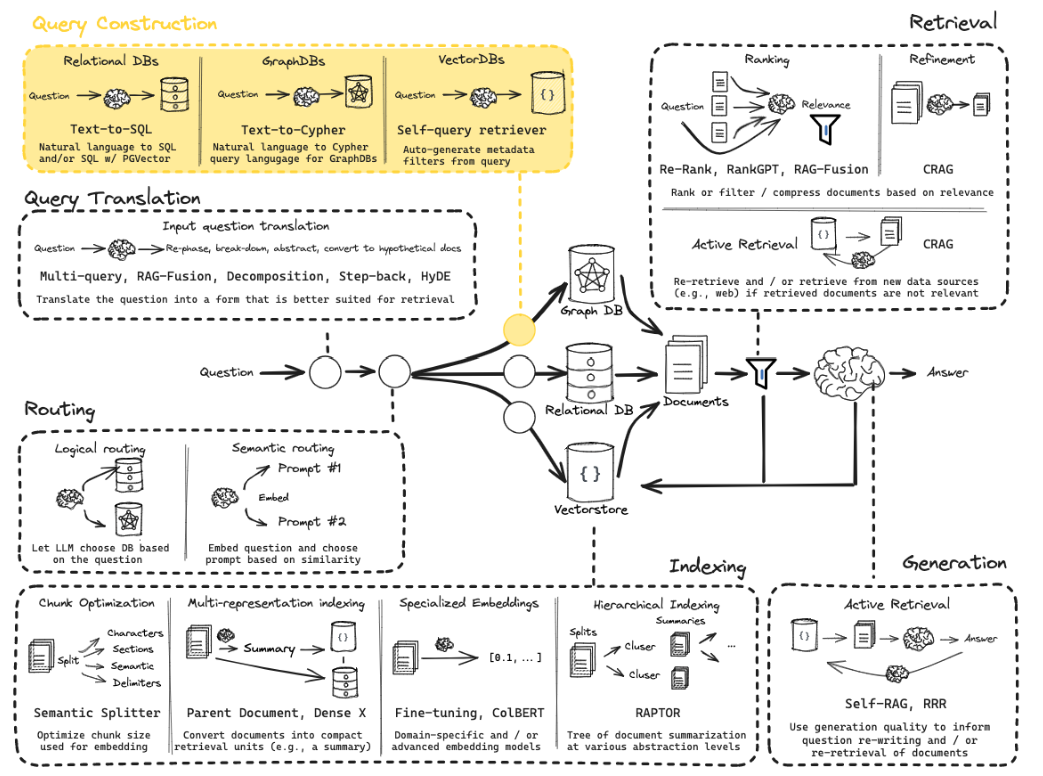

Converting the Natural Language into DB domain language query.

## Part 11: Query structuring for metadata filters

Many vectorstores contain metadata fields.

This makes it possible to filter for specific chunks based on metadata.

Let's look at some example metadata we might see in a database of YouTube transcripts.

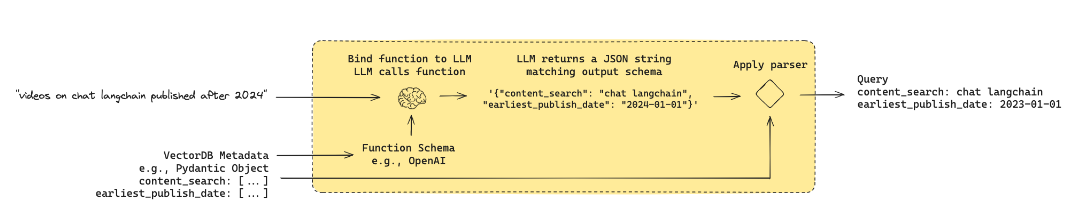

In [13]:
from langchain_community.document_loaders import YoutubeLoader

docs = YoutubeLoader.from_youtube_url(
    "https://www.youtube.com/watch?v=pbAd8O1Lvm4", add_video_info=True
).load()

docs[0].metadata

{'source': 'pbAd8O1Lvm4',
 'title': 'Self-reflective RAG with LangGraph: Self-RAG and CRAG',
 'description': 'Unknown',
 'view_count': 15839,
 'thumbnail_url': 'https://i.ytimg.com/vi/pbAd8O1Lvm4/hq720.jpg',
 'publish_date': '2024-02-07 00:00:00',
 'length': 1058,
 'author': 'LangChain'}

Let’s assume we’ve built an index that:

1. Allows us to perform unstructured search over the contents and title of each document
2. And to use range filtering on view count, publication date, and length.

We want to convert natural langugae into structured search queries.

We can define a schema for structured search queries.

In [14]:
import datetime
from typing import Literal, Optional, Tuple
from langchain_core.pydantic_v1 import BaseModel, Field

class TutorialSearch(BaseModel):
    """Search over a database of tutorial videos about a software library."""

    content_search: str = Field(
        ...,
        description="Similarity search query applied to video transcripts.",
    )
    title_search: str = Field(
        ...,
        description=(
            "Alternate version of the content search query to apply to video titles. "
            "Should be succinct and only include key words that could be in a video "
            "title."
        ),
    )
    min_view_count: Optional[int] = Field(
        None,
        description="Minimum view count filter, inclusive. Only use if explicitly specified.",
    )
    max_view_count: Optional[int] = Field(
        None,
        description="Maximum view count filter, exclusive. Only use if explicitly specified.",
    )
    earliest_publish_date: Optional[datetime.date] = Field(
        None,
        description="Earliest publish date filter, inclusive. Only use if explicitly specified.",
    )
    latest_publish_date: Optional[datetime.date] = Field(
        None,
        description="Latest publish date filter, exclusive. Only use if explicitly specified.",
    )
    min_length_sec: Optional[int] = Field(
    None,
        description="Minimum video length in seconds, inclusive. Only use if explicitly specified.",
    )
    max_length_sec: Optional[int] = Field(
        None,
        description="Maximum video length in seconds, exclusive. Only use if explicitly specified.",
    )

    def pretty_print(self) -> None:
        for field in self.__fields__:
            if getattr(self, field) is not None and getattr(self, field) != getattr(
                self.__fields__[field], "default", None
            ):
                print(f"{field}: {getattr(self, field)}")

Now, we prompt the LLM to produce queries.

In [15]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

system = """You are an expert at converting user questions into database queries. \
You have access to a database of tutorial videos about a software library for building LLM-powered applications. \
Given a question, return a database query optimized to retrieve the most relevant results.

If there are acronyms or words you are not familiar with, do not try to rephrase them."""
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm = llm.with_structured_output(TutorialSearch)
query_analyzer = prompt | structured_llm

In [16]:
query_analyzer.invoke({"question": "rag from scratch"}).pretty_print()

content_search: rag from scratch
title_search: rag from scratch


In [17]:
query_analyzer.invoke(
    {"question": "videos on chat langchain published in 2023"}
).pretty_print()

content_search: chat langchain
title_search: chat langchain
earliest_publish_date: 2023-01-01
latest_publish_date: 2024-01-01


In [18]:
query_analyzer.invoke(
    {"question": "videos that are focused on the topic of chat langchain that are published before 2024"}
).pretty_print()

content_search: chat langchain
title_search: chat langchain
earliest_publish_date: 2024-01-01


In [19]:
query_analyzer.invoke(
    {
        "question": "how to use multi-modal models in an agent, only videos under 5 minutes"
    }
).pretty_print()

content_search: multi-modal models agent
title_search: multi-modal models agent
max_length_sec: 300
